### Final Model Assesment

In this notebook we have run the best model we have been able to produce during our work, on the test data set.
An assessment of our model on independent data set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import pickle
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV

In [2]:
##############################################################################
##########                DATABASE FUNCTIONS                     #############
##############################################################################
#### Read function to import data from the SQL to a pandas dataframe.
def readSQL(query):
    import pandas as pd
    import sqlite3 as sql3
    db = sql3.connect(DB_FILE)
    df = pd.read_sql_query(query, db)
    db.close()
    return(df)

#### Write a pandas dataframe into an SQL table. Use overwrite=True if you want to delete 
#### first a pre-existent table with the same name. Use append=True if you want to append
#### the data in the dataframe to a pre-existent table.
def writeSQL(df,tablename,overwrite=False, append=False):
    import pandas as pd
    import sqlite3 as sql
    db = sql.connect(DB_FILE)
    if (overwrite):
        action = "replace"
    elif (append):
        action = "append"
    else: 
        action = "fail"
    df.to_sql(tablename, db, if_exists=action)
    db.close()
def listTables():
    import sqlite3 as sql3
    db = sql3.connect(DB_FILE)
    cur = db.cursor()
    cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
    res = cur.fetchall()
    cur.close()
    db.close()
    return(res)

In [3]:
def showModelResult(X_Train, Y_Train,X_Dev,Y_Dev,model,pred):
    if(pred.shape==(25479, 2)):
        auc_score = metrics.roc_auc_score(Y_Dev, pred[:,1])
        fpr, tpr, thresholds = metrics.roc_curve(Y_Dev, pred[:,1])
    else:
        auc_score = metrics.roc_auc_score(Y_Dev, pred)
        fpr, tpr, thresholds = metrics.roc_curve(Y_Dev, pred)
    print(auc_score)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    return (auc_score)

In [4]:
import os
cwd = os.getcwd()
DB_FILE = "%s\Data\loans.db" % cwd

In [5]:
X_Train = readSQL('''SELECT * FROM X_train_scaled''')

In [6]:
Y_Train = readSQL('''SELECT * FROM Y_train''')

In [7]:
X_Train = X_Train.drop(["index"],axis=1)

In [8]:
Y_Train = Y_Train.drop(["index"],axis=1)

In [9]:
X_Dev = readSQL('''SELECT * FROM X_dev_scaled''')

In [10]:
X_Dev = X_Dev.drop(["index"],axis=1)

In [11]:
Y_Dev = readSQL('''SELECT * FROM Y_dev''')

In [12]:
Y_Dev = Y_Dev.drop(["index"],axis=1)

In [13]:
X_Test = readSQL('''SELECT * FROM X_test_scaled''')

In [14]:
X_Test = X_Test.drop(["index"],axis=1)

In [15]:
Y_Test = readSQL('''SELECT * FROM Y_test''')

In [16]:
Y_Test = Y_Test.drop(["index"],axis=1)

In [17]:
Y_Train = Y_Train.values.ravel()
Y_Dev = Y_Dev.values.ravel()
Y_Test = Y_Test.values.ravel()

### MODEL Assessment

<b> XGBoost AUC final score

In [18]:
filename= "%s\Models\XGB_best_model.sav" % cwd
mod_xgb = pickle.load(open(filename, 'rb'))

In [19]:
mod_xgb.fit(X_Train, Y_Train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=3, missing=nan, n_estimators=500,
       n_jobs=4, nthread=None, objective='binary:logistic',
       random_state=1207, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)

In [20]:
pred_train = mod_xgb.predict_proba(X_Train)

In [21]:
pred_dev = mod_xgb.predict_proba(X_Dev)

In [22]:
pred_test = mod_xgb.predict_proba(X_Test)

In [23]:
train_score = metrics.roc_auc_score(Y_Train, pred_train[:,1])

In [24]:
dev_score = metrics.roc_auc_score(Y_Dev, pred_dev[:,1])

In [25]:
test_score = metrics.roc_auc_score(Y_Test, pred_test[:,1])

In [26]:
print(train_score)
print(dev_score)
print(test_score)

0.7379012938833023
0.7041575954287301
0.6988406393527397


0.6988406393527397


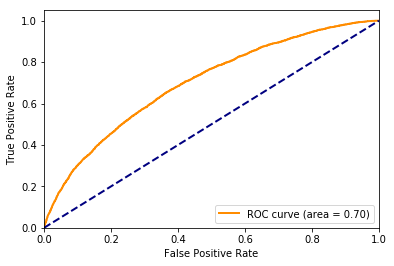

0.6988406393527397

In [27]:
showModelResult(X_Train, Y_Train,X_Test,Y_Test,mod_xgb,pred_test[:,1])

<h3>our final AUC Score is 0.6988406393527397

<b> XGBoost Final calibration

In [28]:
fop_dev, mpv_dev = calibration_curve(Y_Dev, pred_dev[:,1], n_bins=10, normalize=True)
fop_test, mpv_test = calibration_curve(Y_Test, pred_test[:,1], n_bins=10, normalize=True)

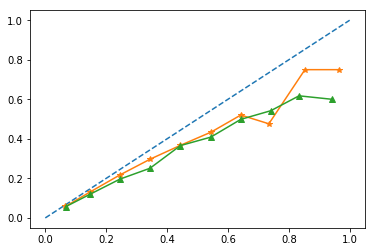

In [29]:
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
pyplot.plot(mpv_dev, fop_dev, marker='*')
pyplot.plot(mpv_test, fop_test, marker='^')
pyplot.show()

In [30]:
print(brier_score_loss(Y_Dev, pred_dev[:,1]))
print(brier_score_loss(Y_Test,pred_test[:,1]))

0.1361149630695373
0.13272216490039845
